In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import scale, label_binarize

In [2]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import descartes
import sys
import sklearn
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/code/functions/')
from gis_processing import *
import pickle

In [3]:
data_dir = '/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/data'
model_dir = '/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/models'

In [4]:
weather_rename_dict = pd.read_pickle(os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_rename_dictionary.pkl'))

In [5]:
target_df1 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_1.pkl'))
target_df2 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_2.pkl'))
target_df = target_df1.append(target_df2)
target_df.rename(columns = weather_rename_dict, inplace = True)

In [6]:
non_mod_cols = ['GRID_ID','month_id','MONTH','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m', 'month_id_old', 'YEAR']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']

## Binary Target Variable

In [9]:
train_data = target_df[(target_df['YEAR']>=1990) & (target_df['YEAR']<=2005)]
X_train = train_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_train.drop(y, inplace = True, axis =1)
    except:
        pass
Y_train_bin = train_data['Y_bin_new_fire_month']

In [10]:
test_data = target_df[target_df['YEAR']>2005]
X_test = test_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_test.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test_bin = test_data['Y_bin_new_fire_month'] 

### Random forest

#### Run RF with different hyperparameters to generate different feature importance lists for LR

In [11]:
rf_clf_bin = {}
rf_clf_bin['bal_entropy'] = RandomForestClassifier(n_estimators = 100, class_weight= 'balanced_subsample', \
                                                criterion = 'entropy').fit(X_train, Y_train_bin)
rf_clf_bin['entropy']= RandomForestClassifier(n_estimators = 100, criterion = 'entropy').fit(X_train, Y_train_bin)
rf_clf_bin['bal_gini'] = RandomForestClassifier(n_estimators = 100, class_weight= 'balanced_subsample').fit(X_train, Y_train_bin)
rf_clf_bin['gini']= RandomForestClassifier(n_estimators = 100).fit(X_train, Y_train_bin)

In [12]:
y_preds_rf_bin = {}
y_proba_rf_bin = {}
##Predictions on class_weight = 'balanced_subsample' and criterion = 'entropy'
y_preds_rf_bin['bal_entropy'] = rf_clf_bin['bal_entropy'].predict(X_test)
y_proba_rf_bin['bal_entropy'] = rf_clf_bin['bal_entropy'].predict_proba(X_test)[:,1]

##Predictions with no adjustments for class_weight and and criterion = 'entropy'
y_preds_rf_bin['entropy'] = rf_clf_bin['entropy'].predict(X_test)
y_proba_rf_bin['entropy'] = rf_clf_bin['entropy'].predict_proba(X_test)[:,1]

##Predictions on class_weight = 'balanced_subsample' and criterion = 'gini'
y_preds_rf_bin['bal_gini'] = rf_clf_bin['bal_gini'].predict(X_test)
y_proba_rf_bin['bal_gini'] = rf_clf_bin['bal_gini'].predict_proba(X_test)[:,1]

##Predictions with no adjustments for class_weight and and criterion = 'gini'
y_preds_rf_bin['gini'] = rf_clf_bin['gini'].predict(X_test)
y_proba_rf_bin['gini'] = rf_clf_bin['gini'].predict_proba(X_test)[:,1]

#### Get feature importances

In [23]:
feat_import = {}
rf_bin_mod_list = ['bal_entropy', 'entropy', 'bal_gini', 'gini']
for m in rf_bin_mod_list:
    feat_import[m] = pd.DataFrame()
    feat_import[m]['col'] = X_train.columns
    feat_import[m]['feature_importance'] = rf_clf_bin[m].feature_importances_
    feat_import[m].sort_values(['feature_importance'], ascending = False, inplace = True)
    print(feat_import[m].head(10))

                         col  feature_importance
71   hist_fire_area_prop_10y            0.028396
155         2m_tmp_18hrs_10y            0.020138
67          hist_cl_size_10y            0.017992
120           2m_tmp_0hrs_5y            0.017930
57              2m_tmp_18hrs            0.017555
70    hist_fire_area_prop_5y            0.016992
91           2m_tmp_18hrs_1y            0.016331
64              hist_bin_10y            0.014873
123          2m_tmp_18hrs_5y            0.014082
37             tot_prcp_0hrs            0.014060
                         col  feature_importance
123          2m_tmp_18hrs_5y            0.020868
71   hist_fire_area_prop_10y            0.016510
155         2m_tmp_18hrs_10y            0.015762
91           2m_tmp_18hrs_1y            0.013996
152          2m_tmp_0hrs_10y            0.013987
120           2m_tmp_0hrs_5y            0.013883
70    hist_fire_area_prop_5y            0.013582
29           adj_fire_bcount            0.012907
153          2m_tmp_

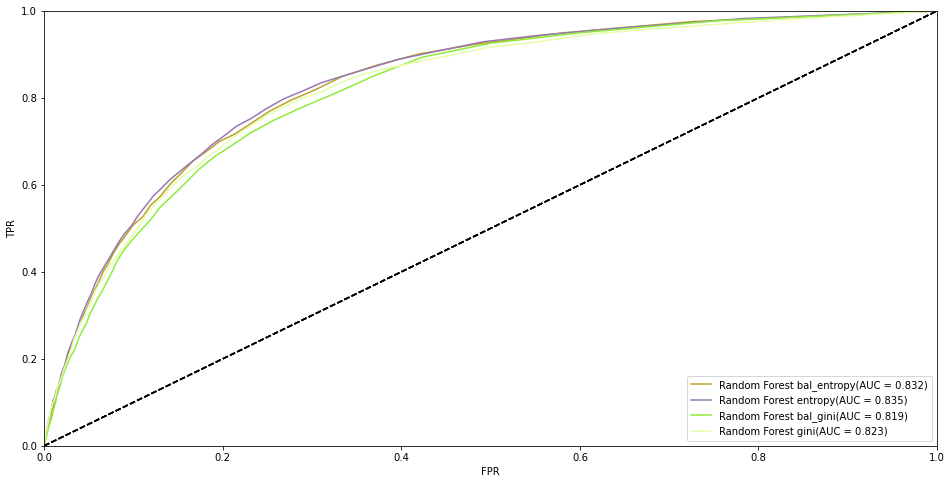

In [14]:
# Run this so your plots show properly
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12
plt.figure(figsize=(16,8))
for m in rf_bin_mod_list:
    fpr_bal, tpr_bal, threshold = roc_curve(Y_test_bin, y_proba_rf_bin[m])
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    roc_auc = auc(fpr_bal, tpr_bal)
    plt.plot(fpr_bal, tpr_bal, color = c, label = f'Random Forest {m}' '(AUC = %0.3f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc="lower right")
plt.show()

In [15]:
for m in rf_bin_mod_list:
    print(m)
    print(pd.DataFrame(confusion_matrix(Y_test_bin, y_preds_rf_bin[m], normalize = 'true', labels = [0,1]), \
                   columns = ['0', '1'], index = ['0','1']))

bal_entropy
          0         1
0  0.991816  0.008184
1  0.927647  0.072353
entropy
          0         1
0  0.988696  0.011304
1  0.889947  0.110053
bal_gini
          0         1
0  0.992532  0.007468
1  0.941356  0.058644
gini
          0         1
0  0.986598  0.013402
1  0.877761  0.122239


In [16]:
corr_cols = list(X_train.columns)
corr_cols.append('Y_fire_class_size')
corr_cols.append('Y_bin')
X_train_corr = np.corrcoef(target_df[corr_cols].transpose())

In [17]:
print(X_train_corr.shape)
X_train_corr_df = pd.DataFrame(X_train_corr, columns = corr_cols, index = corr_cols)
X_train_corr_df.to_csv(os.path.join(data_dir, 'model_outputs/X_train_correlation_matrix.csv'))

(174, 174)


### Logistic Regression on the top X features from feature importances in random forest

In [18]:
def select_features_corr_imp(df, feat_import, rho_cutoff, n_features):
    feat_import.sort_values(['feature_importance'], inplace = True, ascending = False)
    full_feature_list = feat_import['col'].tolist()
    selected_features = [feat_import['col'].iloc[0]]
    i = 1
    while len(selected_features)<= n_features:
        f = full_feature_list[i]
        #print(f)
        test_features = selected_features + [f]
        corr_df = df[test_features].corr()
        #print(corr_df)
        #print(corr_df[corr_df[f]!=1][f].max())
        if corr_df[corr_df[f]!=1][f].max()< rho_cutoff:
            selected_features.append(f)
            i+= 1
        else:
            i+= 1
        
            
    #final full correlation dataframe for sanity check
    output_corr_df = df[selected_features].corr()
    return selected_features, output_corr_df

#### Read in feature importances from decision tree

In [19]:
feat_import['DT_jack'] = pd.read_csv(os.path.join(data_dir, 'feature_importances/featureimportance_DT.csv'))
feat_import['DT_jack'].rename(columns = {'feature':'col', 'feature score': 'feature_importance'}, inplace = True)
if 'DT_jack' not in rf_bin_mod_list:
    rf_bin_mod_list.append('DT_jack')

In [25]:
top_feats = {}
corr_df = {}
for i in np.arange(20, 35, 5):
    top_feats[i] = {}
    corr_df[i] = {}
    #Try feature selection with two different RF models
    for m in rf_bin_mod_list:
        print(i, m)
        top_feats[i][m], corr_df[i][m] = select_features_corr_imp(X_train, feat_import[m], 0.75, i)
        print(top_feats[i][m])

20 bal_entropy
['hist_fire_area_prop_10y', '2m_tmp_18hrs_10y', 'hist_cl_size_10y', 'tot_prcp_0hrs', 'adj_fire_bcount', 'tot_prcp_18hrs_10y', 'hist_fire_area_prop_1y', 'hist_cl_size_1y', 'U_wind_10m_0hrs', '2m_dewpoint_tmp_6hrs_10y', 'tot_prcp_0hrs_1y', 'hist_fire_area_prop_1m', 'U_wind_10m_12hrs', 'V_wind_10m_12hrs', 'V_wind_10m_0hrs_1y', 'U_wind_10m_18hrs_1y', 'Structure Arsons', 'V_wind_10m_18hrs', 'leaf_high_veg_12hrs', 'surface_pressure_18hrs', 'elev_range']
20 entropy
['2m_tmp_18hrs_5y', 'hist_fire_area_prop_10y', 'adj_fire_bcount', 'tot_prcp_18hrs', 'hist_prop_area_fire_1m', 'tot_prcp_12hrs_10y', 'tot_area_fire_prev_1yr', 'hist_bin_10y', 'hist_cl_size_1y', 'U_wind_10m_18hrs', '2m_dewpoint_tmp_0hrs', 'tot_prcp_0hrs_1y', 'U_wind_10m_0hrs_5y', 'V_wind_10m_18hrs_1y', 'V_wind_10m_0hrs', 'U_wind_10m_6hrs', 'V_wind_10m_12hrs', 'surface_pressure_18hrs_10y', 'Total Arsons', 'leaf_high_veg_0hrs', 'hist_bin_no_leak_1m']
20 bal_gini
['2m_tmp_18hrs_10y', 'hist_fire_area_prop_10y', 'hist_cl_si

#### Scale features

In [27]:
X_train_scaled = pd.DataFrame(scale(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scale(X_test), columns = X_test.columns)

#### Subset by out feature importance subset dictionary we created above

In [28]:
X_train_LR = {}
X_test_LR = {}
for i in list(top_feats.keys()):
    X_train_LR[i] = {}
    X_test_LR[i] = {}
    for m in rf_bin_mod_list:
        X_train_LR[i][m] = X_train_scaled[top_feats[i][m]]
        X_test_LR[i][m] = X_test_scaled[top_feats[i][m]]

In [29]:
#regularization hyperparam options
cs = [10**i for i in range(-4, 2)] 

In [31]:
list(top_feats.keys())

[20, 25, 30]

#### Train and score modeling 
We also will identify the best regularization hyperparameter for each # of top features

In [30]:
### Fitting LR using diff regularization, number of features & feature selection method
LR_bin = {}
LR_score = {}
LR_preds = {}
LR_auc = {}
LR_max_auc_ind = {}
for i in list(top_feats.keys()):
    LR_bin[i] = {}
    LR_score[i] = {}
    LR_preds[i] = {}
    LR_auc[i] = {}
    LR_max_auc_ind[i] = {}
    for m in rf_bin_mod_list:
        LR_bin[i][m] = {}
        LR_score[i][m] = {}
        LR_preds[i][m] = {}
        LR_auc[i][m] = []
        for c in cs:
            LR_bin[i][m][c] = LogisticRegression(C = c, class_weight = 'balanced').fit(X_train_LR[i][m], Y_train_bin)
            LR_score[i][m][c] = LR_bin[i][m][c].predict_proba(X_test_LR[i][m])[:,1]
            LR_preds[i][m][c] = LR_bin[i][m][c].predict(X_test_LR[i][m])
            ##Find best feature # + regularization combo
            fpr, tpr, thresholds = roc_curve(Y_test_bin, LR_score[i][m][c])
            LR_auc[i][m].append(auc(fpr, tpr))
        LR_max_auc_ind[i][m] = LR_auc[i][m].index(np.max(LR_auc[i][m]))
    print(LR_max_auc_ind)

{20: {'bal_entropy': 1, 'entropy': 1, 'bal_gini': 1, 'gini': 1}}
{20: {'bal_entropy': 1, 'entropy': 1, 'bal_gini': 1, 'gini': 1}, 25: {'bal_entropy': 1, 'entropy': 1, 'bal_gini': 1, 'gini': 1}}
{20: {'bal_entropy': 1, 'entropy': 1, 'bal_gini': 1, 'gini': 1}, 25: {'bal_entropy': 1, 'entropy': 1, 'bal_gini': 1, 'gini': 1}, 30: {'bal_entropy': 1, 'entropy': 1, 'bal_gini': 1, 'gini': 1}}


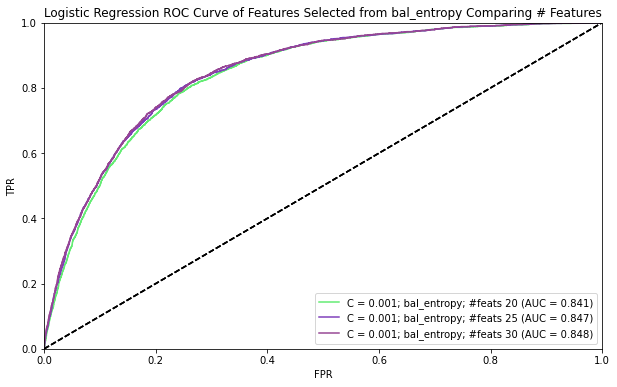

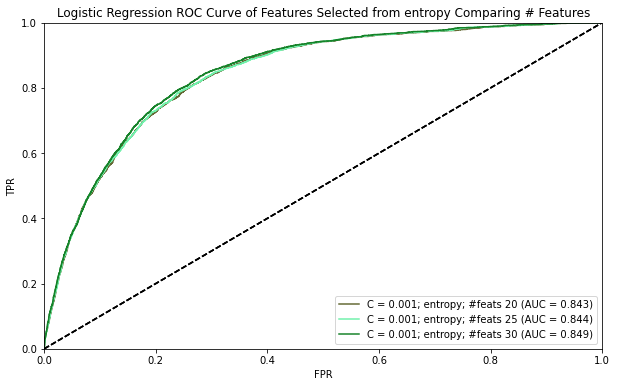

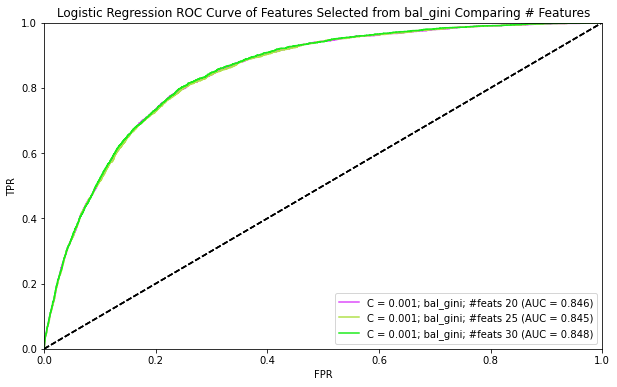

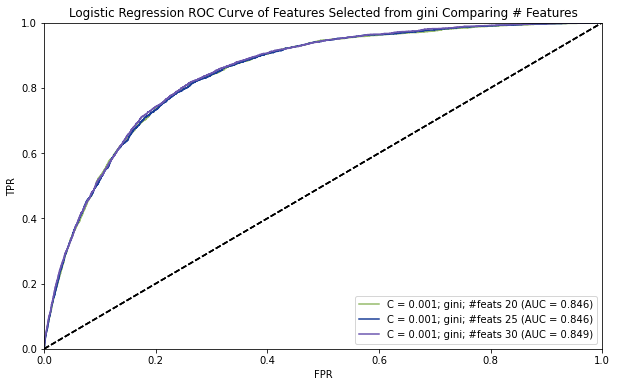

In [32]:
from sklearn.metrics import roc_curve, auc
for m in rf_bin_mod_list:
    plt.figure(figsize = (10,6))
    for i in top_feats.keys():
        c = cs[LR_max_auc_ind[i][m]]
        fpr, tpr, thresholds = roc_curve(Y_test_bin, LR_score[i][m][c])
        roc_auc = auc(fpr, tpr)

        #chooses a random color for plotting
        col = (np.random.rand(), np.random.rand(), np.random.rand())

        #plot current model ROC curve
        plt.plot(fpr, tpr, color = col, label = f"C = {c}; " + f'{m}; ' f'#feats {i}' + ' (AUC = %0.3f)' % roc_auc) 
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    plt.title(f'Logistic Regression ROC Curve of Features Selected from {m} Comparing # Features')
    plt.legend(loc="lower right")
    plt.show()

In [33]:
for i in top_feats.keys():
    for m in rf_bin_mod_list:
        c = cs[LR_max_auc_ind[i][m]]
        print(f"{i} features, using {m} feature importance & best regularization C = {c}")
        cm = pd.DataFrame(confusion_matrix(Y_test_bin, LR_preds[i][m][c], normalize = 'true'), columns = ['0', '1'],\
                  index = ['0','1'])
        print(cm)

20 features, using bal_entropy feature importance & best regularization C = 0.001
          0         1
0  0.767366  0.232634
1  0.231150  0.768850
20 features, using entropy feature importance & best regularization C = 0.001
          0         1
0  0.788900  0.211100
1  0.257426  0.742574
20 features, using bal_gini feature importance & best regularization C = 0.001
          0         1
0  0.779130  0.220870
1  0.233435  0.766565
20 features, using gini feature importance & best regularization C = 0.001
          0         1
0  0.775959  0.224041
1  0.230388  0.769612
25 features, using bal_entropy feature importance & best regularization C = 0.001
          0         1
0  0.779386  0.220614
1  0.237624  0.762376
25 features, using entropy feature importance & best regularization C = 0.001
          0         1
0  0.788286  0.211714
1  0.253618  0.746382
25 features, using bal_gini feature importance & best regularization C = 0.001
          0         1
0  0.779488  0.220512
1  0.23

In [27]:
cm = pd.DataFrame(confusion_matrix(Y_test_bin, LR_preds[30][0.01], normalize = 'true'), columns = ['0', '1'],\
                  index = ['0','1'])
print(cm)

          0         1
0  0.761255  0.238745
1  0.187500  0.812500


#### Best performance combination for LR: 
Top 30 features selected using correlation feature importance function and taking feature importance from RF model with criteron = 'entropy', 
C = 0.001

In [42]:
##Output best LR model:
with open(os.path.join(model_dir, 'LR_20gini_1990_2005.pkl'), 'wb') as handle:
    pickle.dump(LR_bin[20]['gini'][0.001], handle)

In [44]:
##Output list of features used in best LR model (for CV)
best_LR_bin_features = list(X_train_LR[20]['gini'].columns)
with open(os.path.join(model_dir, 'feature_lists/RF_gini_top20_features_1990_2005.pkl'), 'wb') as handle:
    pickle.dump(best_LR_bin_features, handle)

### SVM

#### We'll use feature importances from RF with criterion = 'entropy'

In [34]:
X_train_SVM = {}
X_test_SVM = {}
for i in list(top_feats.keys()):
    X_train_SVM[i] = X_train_scaled[top_feats[i]['entropy']]
    print(X_train_SVM[i].shape)
    print(Y_train_bin.shape)
    X_test_SVM[i] = X_test_scaled[top_feats[i]['entropy']]

(25212, 21)
(25212,)
(25212, 26)
(25212,)
(25212, 31)
(25212,)


#### Testing different regularizations, # top features

In [35]:
linSVC = {}
linSVC_score = {}
linSVC_preds = {}
linSVC_auc = {}
linSVC_max_auc_ind = {}

In [36]:
### Fitting LR using diff regularization, number of features & feature selection method
linSVC_bin = {}
linSVC_score = {}
linSVC_preds = {}
linSVC_auc = {}
linSVC_max_auc_ind = {}
for i in list(top_feats.keys()):
    linSVC_bin[i] = {}
    linSVC_score[i] = {}
    linSVC_preds[i] = {}
    linSVC_auc[i] = {}
    linSVC_max_auc_ind[i] = {}
    for m in rf_bin_mod_list:
        linSVC_bin[i][m] = {}
        linSVC_score[i][m] = {}
        linSVC_preds[i][m] = {}
        linSVC_auc[i][m] = []
        for c in cs:
            linSVC_bin[i][m][c] = LinearSVC(C = c, class_weight = 'balanced', dual = False).fit(X_train_LR[i][m], Y_train_bin)
            linSVC_score[i][m][c] = linSVC_bin[i][m][c].decision_function(X_test_LR[i][m])
            linSVC_preds[i][m][c] = linSVC_bin[i][m][c].predict(X_test_LR[i][m])
            ##Find best feature # + regularization combo
            fpr, tpr, thresholds = roc_curve(Y_test_bin, linSVC_score[i][m][c])
            linSVC_auc[i][m].append(auc(fpr, tpr))
        linSVC_max_auc_ind[i][m] = linSVC_auc[i][m].index(np.max(linSVC_auc[i][m]))
    print(linSVC_max_auc_ind)

{20: {'bal_entropy': 0, 'entropy': 0, 'bal_gini': 0, 'gini': 0}}
{20: {'bal_entropy': 0, 'entropy': 0, 'bal_gini': 0, 'gini': 0}, 25: {'bal_entropy': 0, 'entropy': 0, 'bal_gini': 0, 'gini': 0}}
{20: {'bal_entropy': 0, 'entropy': 0, 'bal_gini': 0, 'gini': 0}, 25: {'bal_entropy': 0, 'entropy': 0, 'bal_gini': 0, 'gini': 0}, 30: {'bal_entropy': 0, 'entropy': 0, 'bal_gini': 0, 'gini': 0}}


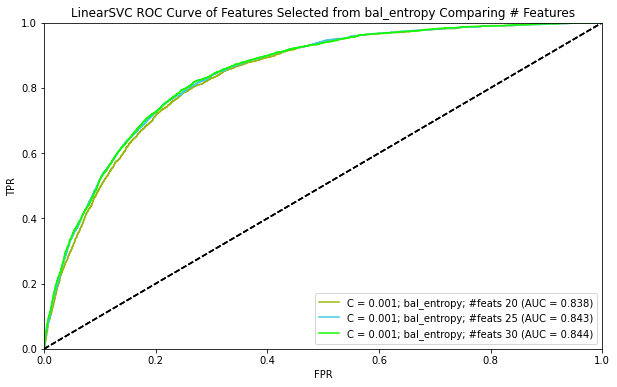

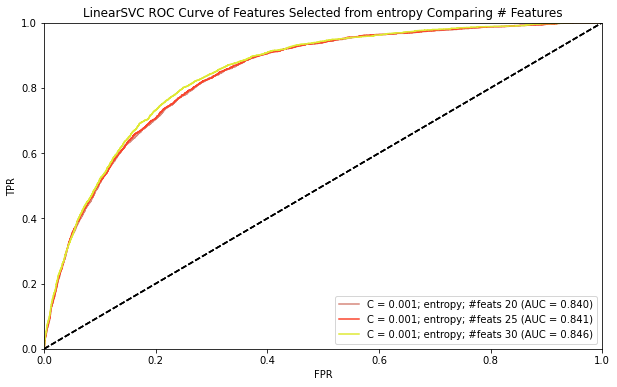

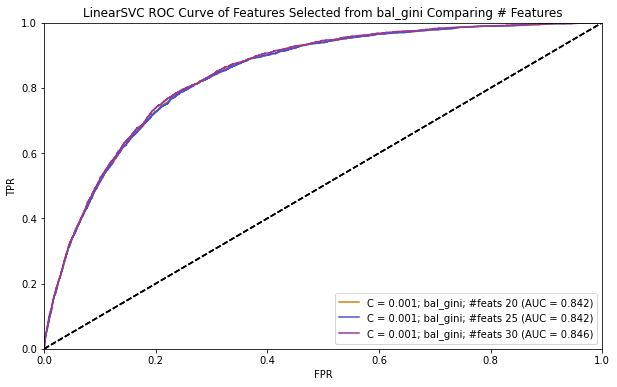

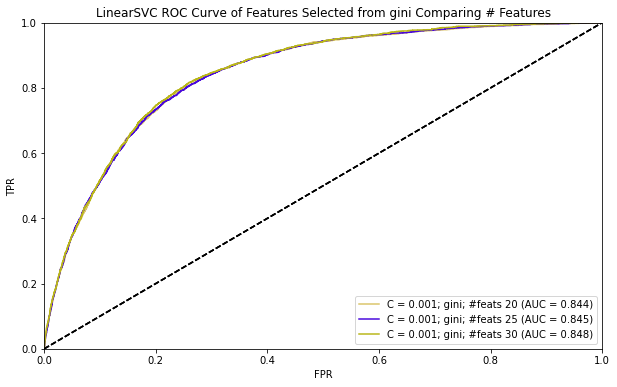

In [38]:
from sklearn.metrics import roc_curve, auc
for m in rf_bin_mod_list:
    plt.figure(figsize = (10,6))
    for i in top_feats.keys():
        c = cs[LR_max_auc_ind[i][m]]
        fpr, tpr, thresholds = roc_curve(Y_test_bin, linSVC_score[i][m][c])
        roc_auc = auc(fpr, tpr)

        #chooses a random color for plotting
        col = (np.random.rand(), np.random.rand(), np.random.rand())

        #plot current model ROC curve
        plt.plot(fpr, tpr, color = col, label = f"C = {c}; " + f'{m}; ' f'#feats {i}' + ' (AUC = %0.3f)' % roc_auc) 
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    plt.title(f'LinearSVC ROC Curve of Features Selected from {m} Comparing # Features')
    plt.legend(loc="lower right")
    plt.show()

In [39]:
for m in rf_bin_mod_list:
    for i in top_feats.keys():
        c = cs[linSVC_max_auc_ind[i][m]]
        print(f"{i} features, using {m} feature importance & best regularization C = {c}")
        cm = pd.DataFrame(confusion_matrix(Y_test_bin, linSVC_preds[i][m][c], normalize = 'true'), columns = ['0', '1'],\
                  index = ['0','1'])
        print(cm)

20 features, using bal_entropy feature importance & best regularization C = 0.0001
          0         1
0  0.731202  0.268798
1  0.189261  0.810739
25 features, using bal_entropy feature importance & best regularization C = 0.0001
          0         1
0  0.743836  0.256164
1  0.190784  0.809216
30 features, using bal_entropy feature importance & best regularization C = 0.0001
          0         1
0  0.742916  0.257084
1  0.193831  0.806169
20 features, using entropy feature importance & best regularization C = 0.0001
          0         1
0  0.740153  0.259847
1  0.197639  0.802361
25 features, using entropy feature importance & best regularization C = 0.0001
          0         1
0  0.741483  0.258517
1  0.199543  0.800457
30 features, using entropy feature importance & best regularization C = 0.0001
          0         1
0  0.743478  0.256522
1  0.191546  0.808454
20 features, using bal_gini feature importance & best regularization C = 0.0001
          0         1
0  0.742813  0.2

#### Output best SVM model

In [45]:
##Output best SVM model:
with open(os.path.join(model_dir, 'linSVC_30gini_1990_2005.pkl'), 'wb') as handle:
    pickle.dump(linSVC_bin[30]['gini'][0.0001], handle)

In [46]:
##Output list of features used in best linearSVC model
best_linSVC_bin_features = list(X_train_LR[30]['gini'].columns)
with open(os.path.join(model_dir, 'feature_lists/RF_gini_top30_features_1990_2005.pkl'), 'wb') as handle:
    pickle.dump(best_linSVC_bin_features, handle)

## Mutli-Class Fire Size

In [91]:
Y_train_multi = train_data[['Y_max_new_fire_size_month']]
Y_test_multi = test_data[['Y_max_new_fire_size_month']]

### Random Forest

In [92]:
rf_clf_multi = RandomForestClassifier(n_estimators = 100).fit(X_train, Y_train_multi)

<ipython-input-92-5a18a21ecdc3>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf_multi = RandomForestClassifier(n_estimators = 100).fit(X_train, Y_train_multi)


In [93]:
y_preds_rf_multi = rf_clf_multi.predict(X_test)
y_proba_rf_multi = rf_clf_multi.predict_proba(X_test)
#for multi-class problem have to binarize
y_rf_multi_bin = label_binarize(Y_test_multi, classes=[0,1, 2, 3])
n_classes = y_rf_multi_bin.shape[1]

In [49]:
#read in decision tree feature importances 
feat_import_multi_DT = pd.read_csv(os.path.join(data_dir, 'feature_importances/'))

(4752, 4)

In [99]:
feat_import_multi = pd.DataFrame()
feat_import_multi['col'] = X_train.columns
feat_import_multi['feature_importance'] = rf_clf_multi.feature_importances_
feat_import_multi.sort_values(['feature_importance'], ascending = False, inplace = True)
feat_import_multi.head(10)

,col,feature_importance
123,2m_tmp_18hrs_5y,0.013136
72,tot_area_fire_prev_1yr,0.012349
91,2m_tmp_18hrs_1y,0.011237
68,hist_fire_area_prop_1m,0.011154
75,hist_prop_area_fire_1m,0.010953
69,hist_fire_area_prop_1y,0.010815
155,2m_tmp_18hrs_10y,0.010741
152,2m_tmp_0hrs_10y,0.010638
120,2m_tmp_0hrs_5y,0.010429
88,2m_tmp_0hrs_1y,0.009816


0
1
2
3


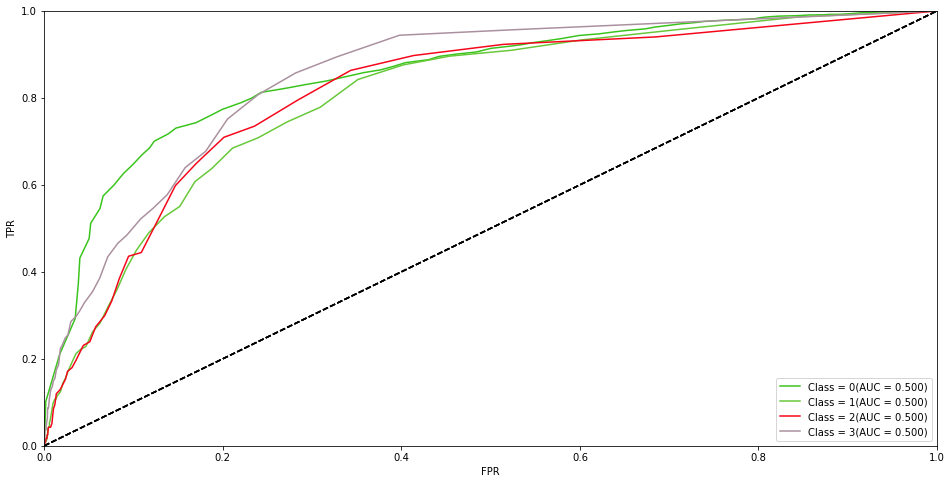

In [96]:
# Run this so your plots show properly
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12
plt.figure(figsize=(16,8))
fpr_multi_rf = dict()
tpr_multi_rf = dict()
roc_auc_multi_rf = dict()
for i in range(4):
    print(i)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    fpr_multi_rf[i], tpr_multi_rf[i], _ = roc_curve(y_rf_multi_bin[:,i], y_proba_rf_multi[:,i])
    roc_auc_multi_rf[i] = auc(fpr_multi_rf[i], fpr_multi_rf[i])
    plt.plot(fpr_multi_rf[i], tpr_multi_rf[i], color = c, label = f'Class = {i}'+'(AUC = %0.3f)' % roc_auc_multi_rf[i]) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc="lower right")
plt.show()

In [191]:
Y_test_multi_np[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [97]:
Y_test_multi_np = Y_test_multi.to_numpy().reshape(Y_test_multi.shape[0])
print(pd.DataFrame(confusion_matrix(Y_test_multi_np, y_preds_rf_multi, labels = [0,1,2,3]), columns = ['0', '1', '2', '3'],
                  index = ['0', '1', '2', '3']))
recall_multi = np.sum([10,6, 10])/ np.sum([272, 106, 142])
recall_multi

      0   1  2   3
0  4156  13  1   6
1   272  16  3   7
2   109   5  1   2
3   140   6  4  11


0.05

### Logistic Regression

In [101]:
top_feats_multi = {}
corr_df_multi = {}
for i in np.arange(20, 40, 5):
    top_feats_multi[i] = {}
    corr_df_multi[i] = {}
    #Try feature selection with two different RF models
    top_feats_multi[i], corr_df_multi[i] = select_features_corr_imp(X_train, feat_import_multi, 0.75, i)
    print(top_feats_multi[i])

['2m_tmp_18hrs_5y', 'tot_area_fire_prev_1yr', 'hist_fire_area_prop_1m', 'tot_prcp_6hrs_10y', 'hist_fire_area_prop_5y', 'tot_prcp_18hrs_1y', 'tot_prcp_18hrs', 'U_wind_10m_18hrs', 'V_wind_10m_0hrs', 'adj_fire_count', 'adj_fire_bcount', '2m_dewpoint_tmp_0hrs', 'U_wind_10m_0hrs_1y', 'hist_cl_size_no_leak_1m', 'U_wind_10m_12hrs', 'V_wind_10m_18hrs_5y', 'V_wind_10m_12hrs', 'surface_pressure_12hrs', 'hist_cl_size_1y', 'Total Arsons', 'Unemployment']
['2m_tmp_18hrs_5y', 'tot_area_fire_prev_1yr', 'hist_fire_area_prop_1m', 'tot_prcp_6hrs_10y', 'hist_fire_area_prop_5y', 'tot_prcp_18hrs_1y', 'tot_prcp_18hrs', 'U_wind_10m_18hrs', 'V_wind_10m_0hrs', 'adj_fire_count', 'adj_fire_bcount', '2m_dewpoint_tmp_0hrs', 'U_wind_10m_0hrs_1y', 'hist_cl_size_no_leak_1m', 'U_wind_10m_12hrs', 'V_wind_10m_18hrs_5y', 'V_wind_10m_12hrs', 'surface_pressure_12hrs', 'hist_cl_size_1y', 'Total Arsons', 'Unemployment', 'MEDIAN_AGE_FEM', 'hist_cl_size_10y', 'leaf_high_veg_0hrs', 'AGE4564_TOT', 'leaf_high_veg_18hrs']
['2m_tmp

In [102]:
X_train_LR_multi = {}
X_test_LR_multi = {}
for i in list(top_feats_multi.keys()):
    X_train_LR_multi[i] = X_train_scaled[top_feats_multi[i]]
    X_test_LR_multi[i] = X_test_scaled[top_feats_multi[i]]

#### Train and score model

In [103]:
#for multi-class problem have to binarize
y_test_multi_bin = label_binarize(Y_test_multi, classes=[0,1, 2, 3])
n_classes = y_test_multi_bin.shape[1]

In [104]:
LR_multi = {}
LR_multi_score = {}
LR_multi_preds = {}
auc_by_class = {}
LR_multi_auc = {}
LR_multi_max_auc_ind = {}
LR_multi_max_auc = {}
for i in list(top_feats_multi.keys()):
    LR_multi[i] = {}
    LR_multi_score[i] = {}
    LR_multi_preds[i] = {}
    auc_by_class[i] = {}
    LR_multi_auc[i] = []
    for c in cs:
        auc_by_class[i][c] = []
        LR_multi[i][c] = LogisticRegression(C = c, class_weight = 'balanced').fit(X_train_LR_multi[i], \
                                            Y_train_multi.to_numpy().reshape(Y_train_multi.shape[0]))
        LR_multi_score[i][c] = LR_multi[i][c].predict_proba(X_test_LR_multi[i])
        LR_multi_preds[i][c] = LR_multi[i][c].predict(X_test_LR_multi[i])
        
        #Loop through the different classes and get average AUC across to find best c for given feature selection
        for n in range(n_classes):
            fpr, tpr, thresholds = roc_curve(y_test_multi_bin[:,n], LR_multi_score[i][c][:,n])
            auc_by_class[i][c].append(auc(fpr, tpr))
        print(auc_by_class[i][c])
        LR_multi_auc[i].append(np.mean(auc_by_class[i][c]))
    LR_multi_max_auc[i] = np.max(LR_multi_auc[i])
    LR_multi_max_auc_ind[i] = LR_multi_auc[i].index(LR_multi_max_auc[i])
print(LR_multi_max_auc_ind)

[0.867513852304172, 0.751054779204576, 0.8483463797379656, 0.8580817721953972]
[0.8666919433801616, 0.7417697085494376, 0.8364174480679334, 0.8467160296069409]
[0.8627703111696468, 0.7414653294075456, 0.8296259416000517, 0.8462533365983405]
[0.8617721304278417, 0.7418412828526052, 0.8278722835357138, 0.8466822070185929]
[0.8616578031875266, 0.7418864876756585, 0.8277063222047041, 0.8467254999316784]
[0.8616469940666242, 0.7418420362663227, 0.827682350012447, 0.846748499291755]
[0.8734135536398467, 0.7484901589100215, 0.8533860721562987, 0.8683273106577681]
[0.8717851180023415, 0.7394137838546454, 0.8427645469716669, 0.857329557830538]
[0.8691614117709663, 0.7381186656741695, 0.8358845277939129, 0.8579261882889965]
[0.8683831550659855, 0.7382979781389475, 0.8346416618261279, 0.8583185303138331]
[0.8682929404799915, 0.7383296215150849, 0.8344609483768061, 0.8583280006385705]
[0.868278389740315, 0.7383281146876499, 0.834455416332439, 0.8583307064456382]
[0.8730111217539377, 0.753153789821

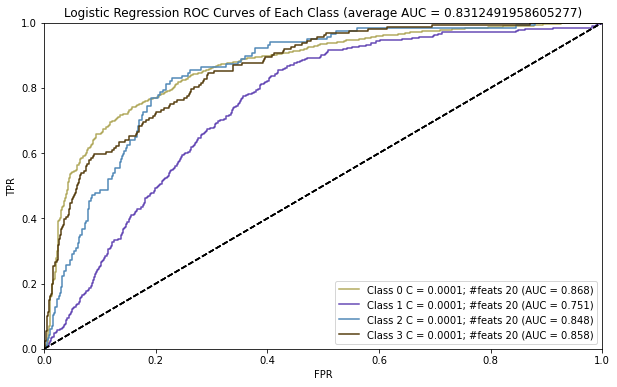

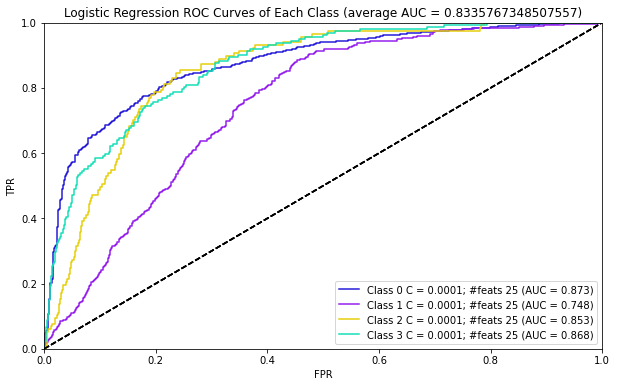

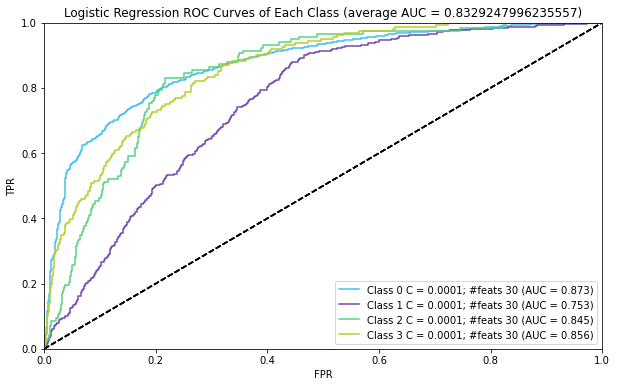

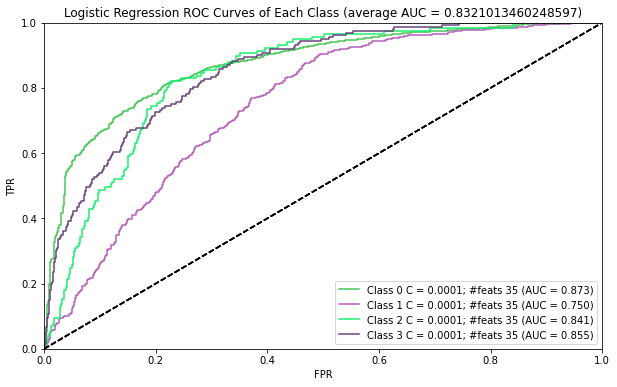

In [107]:
auc_by_class = []
for i in top_feats.keys():
    c = cs[LR_multi_max_auc_ind[i]]
    plt.figure(figsize = (10,6))
    for n in range(n_classes):
        fpr, tpr, threshold = roc_curve(y_test_multi_bin[:,n], LR_multi_score[i][c][:,n])
        roc_auc = auc(fpr, tpr)
        auc_by_class.append(roc_auc)
        #chooses a random color for plotting
        col = (np.random.rand(), np.random.rand(), np.random.rand())
        #plot current model ROC curve
        plt.plot(fpr, tpr, color = col, label = f"Class {n} "+ f"C = {c}; " + f'#feats {i}' + ' (AUC = %0.3f)' % roc_auc) 
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend(loc="lower right")
    mean_auc = np.mean(auc_by_class)
    plt.title(f'Logistic Regression ROC Curves of Each Class (average AUC = {mean_auc})')
    plt.show()

In [111]:
Y_test_multi_np = Y_test_multi.to_numpy().reshape(Y_test_multi.shape[0])
for i in top_feats.keys():
    c = cs[LR_multi_max_auc_ind[i]]
    print(pd.DataFrame(confusion_matrix(Y_test_multi, LR_multi_preds[i][c], labels = [0,1,2,3], normalize = 'true'), columns = ['0', '1', '2', '3'],
                  index = ['0', '1', '2', '3']))

          0         1         2         3
0  0.760536  0.087883  0.071121  0.080460
1  0.238255  0.218121  0.281879  0.261745
2  0.111111  0.179487  0.384615  0.324786
3  0.149068  0.124224  0.211180  0.515528
          0         1         2         3
0  0.747845  0.106801  0.067289  0.078065
1  0.218121  0.241611  0.281879  0.258389
2  0.094017  0.196581  0.384615  0.324786
3  0.111801  0.142857  0.223602  0.521739
          0         1         2         3
0  0.740900  0.102490  0.067289  0.089320
1  0.211409  0.218121  0.302013  0.268456
2  0.119658  0.162393  0.376068  0.341880
3  0.105590  0.136646  0.254658  0.503106
          0         1         2         3
0  0.737548  0.100575  0.071839  0.090038
1  0.214765  0.201342  0.312081  0.271812
2  0.119658  0.136752  0.384615  0.358974
3  0.099379  0.136646  0.267081  0.496894


### SVM

In [115]:
linSVC_multi = {}
linSVC_multi_score = {}
linSVC_multi_preds = {}
linSVC_auc_by_class = {}
linSVC_multi_auc = {}
linSVC_multi_max_auc_ind = {}
linSVC_multi_max_auc = {}
for i in list(top_feats_multi.keys()):
    linSVC_multi[i] = {}
    linSVC_multi_score[i] = {}
    linSVC_multi_preds[i] = {}
    linSVC_auc_by_class[i] = {}
    linSVC_multi_auc[i] = []
    for c in cs:
        linSVC_auc_by_class[i][c] = []
        linSVC_multi[i][c] = LinearSVC(C = c, class_weight = 'balanced', dual = False).fit(X_train_LR_multi[i], \
                                            Y_train_multi.to_numpy().reshape(Y_train_multi.shape[0]))
        linSVC_multi_score[i][c] = linSVC_multi[i][c].decision_function(X_test_LR_multi[i])
        linSVC_multi_preds[i][c] = linSVC_multi[i][c].predict(X_test_LR_multi[i])
        
        #Loop through the different classes and get average AUC across to find best c for given feature selection
        for n in range(n_classes):
            fpr, tpr, thresholds = roc_curve(y_test_multi_bin[:,n], linSVC_multi_score[i][c][:,n])
            linSVC_auc_by_class[i][c].append(auc(fpr, tpr))
        print(linSVC_auc_by_class[i][c])
        linSVC_multi_auc[i].append(np.mean(linSVC_auc_by_class[i][c]))
    linSVC_multi_max_auc[i] = np.max(linSVC_multi_auc[i])
    linSVC_multi_max_auc_ind[i] = linSVC_multi_auc[i].index(linSVC_multi_max_auc[i])
print(linSVC_multi_max_auc_ind)

[0.8704414611270752, 0.816320749315147, 0.8716639467448529, 0.8752798819185795]
[0.868906981694338, 0.8151537114666555, 0.8718741644307987, 0.8700022052327603]
[0.8669189349191145, 0.8144455025721543, 0.8716049382716049, 0.8689699398363798]
[0.8665543349563645, 0.8143430383065671, 0.8716547266709078, 0.8688481785183271]
[0.8665227390644955, 0.8143219427224756, 0.8716584147004859, 0.8688292378688521]
[0.8665173345040442, 0.8143181756538879, 0.8716602587152749, 0.8688238262547165]
[0.8762659143518519, 0.8220964188739177, 0.8737200232345864, 0.8802450378880634]
[0.8741140678214134, 0.8200554211130633, 0.8729676652006748, 0.8760172143445656]
[0.8719988060078757, 0.8191415302736701, 0.8725287896808933, 0.8748144831029113]
[0.8716649704661559, 0.8190330386983421, 0.8724771572668013, 0.8746859572671889]
[0.8716288014846743, 0.8190217374925788, 0.8724642491632782, 0.874668369521248]
[0.8716225654533845, 0.8190209840788613, 0.8724697812076453, 0.8746710753283158]
[0.8763174655438485, 0.82241134

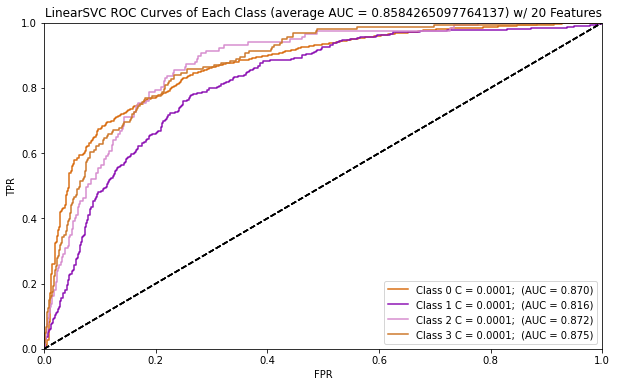

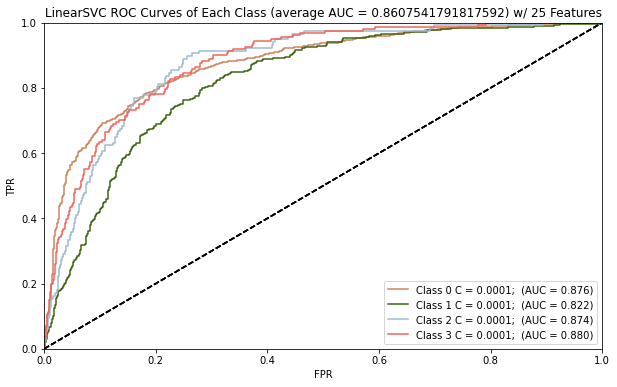

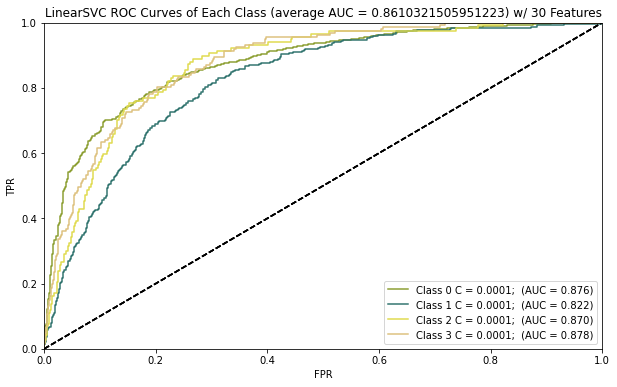

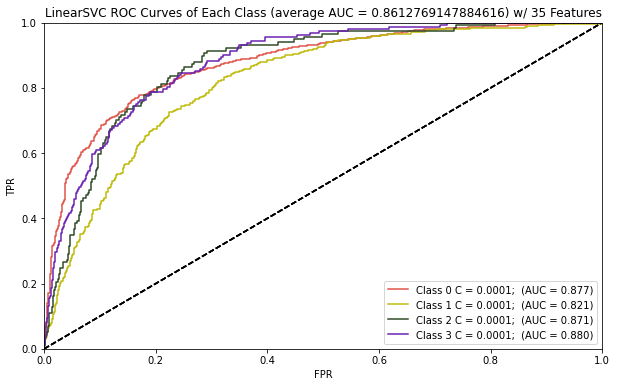

In [119]:
auc_by_class = []
for i in top_feats.keys():
    c = cs[linSVC_multi_max_auc_ind[i]]
    plt.figure(figsize = (10,6))
    for n in range(n_classes):
        fpr, tpr, threshold = roc_curve(y_test_multi_bin[:,n], linSVC_multi_score[i][c][:,n])
        roc_auc = auc(fpr, tpr)
        auc_by_class.append(roc_auc)
        #chooses a random color for plotting
        col = (np.random.rand(), np.random.rand(), np.random.rand())
        #plot current model ROC curve
        plt.plot(fpr, tpr, color = col, label = f"Class {n} "+ f"C = {c}; " + ' (AUC = %0.3f)' % roc_auc) 
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend(loc="lower right")
    mean_auc = np.mean(auc_by_class)
    plt.title(f'LinearSVC ROC Curves of Each Class (average AUC = {mean_auc}) w/ {i} Features')
    plt.show()

In [120]:
Y_test_multi_np = Y_test_multi.to_numpy().reshape(Y_test_multi.shape[0])
for i in top_feats.keys():
    c = cs[linSVC_multi_max_auc_ind[i]]
    print(pd.DataFrame(confusion_matrix(Y_test_multi, linSVC_multi_preds[i][c], labels = [0,1,2,3], normalize = 'true'), columns = ['0', '1', '2', '3'],
                  index = ['0', '1', '2', '3']))

          0         1         2         3
0  0.960249  0.008621  0.011015  0.020115
1  0.664430  0.046980  0.117450  0.171141
2  0.521368  0.068376  0.205128  0.205128
3  0.509317  0.031056  0.118012  0.341615
          0         1         2         3
0  0.954502  0.012213  0.010776  0.022510
1  0.664430  0.063758  0.104027  0.167785
2  0.487179  0.094017  0.188034  0.230769
3  0.472050  0.037267  0.124224  0.366460
          0         1         2         3
0  0.955460  0.008381  0.012213  0.023946
1  0.651007  0.077181  0.134228  0.137584
2  0.555556  0.128205  0.153846  0.162393
3  0.465839  0.062112  0.136646  0.335404
          0         1         2         3
0  0.952347  0.008381  0.012692  0.026580
1  0.644295  0.070470  0.140940  0.144295
2  0.529915  0.119658  0.179487  0.170940
3  0.459627  0.062112  0.124224  0.354037
